In [106]:
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from torch import nn
import random

import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_decision_boundary, accuracy_fn

helper_functions.py already exists, skipping download


### Get the spirals data, visualize

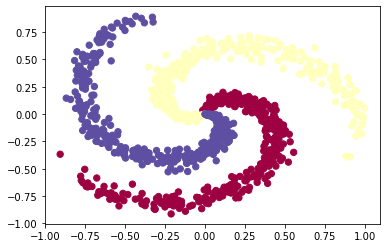

In [107]:
random.seed(42)
import numpy as np
N = 350 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [108]:
X.shape, y.shape

((1050, 2), (1050,))

### 2. Tensor and train rest split

In [109]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X,
    y,
    test_size=0.2,
    random_state=42
)

### 3. Model

In [111]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [112]:
NUM_CLASSES = 3
NUM_FEATURES = 2

In [113]:
class SpiralModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8) -> None:
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.seq(x)
model = SpiralModel(NUM_FEATURES, NUM_CLASSES).to(device)
model

SpiralModel(
  (seq): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [114]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 
                            lr=0.2)

In [115]:
torch.manual_seed(42)

# Set number of epochs
epochs = 150

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model.train()

    # 1. Forward pass
    y_logits = model(X_train) 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) 
    # print(y_logits.size)

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) 
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model(X_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.10124, Acc: 32.62% | Test Loss: 1.06242, Test Acc: 50.95%
Epoch: 10 | Loss: 0.72249, Acc: 69.40% | Test Loss: 0.62326, Test Acc: 76.19%
Epoch: 20 | Loss: 0.49673, Acc: 75.48% | Test Loss: 0.43690, Test Acc: 75.71%
Epoch: 30 | Loss: 0.42970, Acc: 74.17% | Test Loss: 0.37846, Test Acc: 80.48%
Epoch: 40 | Loss: 0.40868, Acc: 80.83% | Test Loss: 0.33016, Test Acc: 81.43%
Epoch: 50 | Loss: 0.36539, Acc: 77.38% | Test Loss: 0.29444, Test Acc: 82.86%
Epoch: 60 | Loss: 0.33727, Acc: 82.14% | Test Loss: 0.25847, Test Acc: 87.14%
Epoch: 70 | Loss: 0.26259, Acc: 88.93% | Test Loss: 0.16563, Test Acc: 94.29%
Epoch: 80 | Loss: 0.18902, Acc: 92.98% | Test Loss: 0.12068, Test Acc: 96.19%
Epoch: 90 | Loss: 0.14782, Acc: 94.40% | Test Loss: 0.15595, Test Acc: 92.86%
Epoch: 100 | Loss: 0.35664, Acc: 90.48% | Test Loss: 0.25202, Test Acc: 90.48%
Epoch: 110 | Loss: 0.19553, Acc: 92.86% | Test Loss: 0.11419, Test Acc: 94.29%
Epoch: 120 | Loss: 0.12182, Acc: 94.40% | Test Loss: 0.07974, T

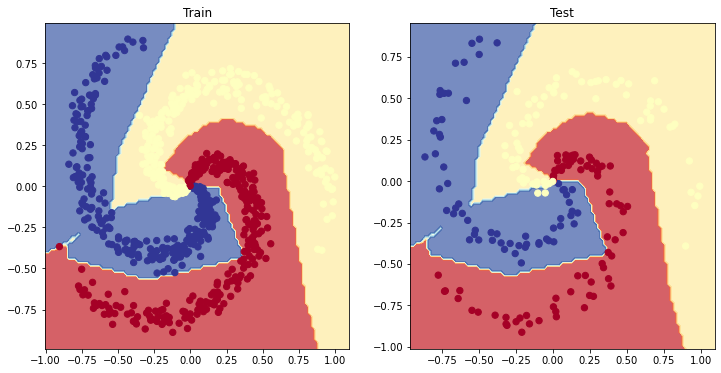

In [116]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)